## Mentoring 7: Clustering
Daniel David Hartama Sitompul - 960275
<br>Telkom Athon #2 - Data Science


# Load libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
import os
warnings.filterwarnings("ignore")

py.offline.init_notebook_mode(connected = True)

# Data Exploration

In [2]:
df = pd.read_csv(r'../data/transactions.csv')
df['trans_date'] = df['trans_date'].replace(['29-Feb-17'],'28-Feb-17') #replace wrong data
df['trans_date']= pd.to_datetime(df['trans_date'],dayfirst=True)

df.head()

,customer_id,trans_date,trans_amount
0,CS5295,2018-02-11,35
1,CS4768,2020-03-15,39
2,CS2122,2018-02-26,52
3,CS1217,2016-11-16,99
4,CS1850,2018-11-20,78


In [3]:
df.shape

(125000, 3)

In [4]:
df.describe()

,trans_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


# Data Visualization

In [5]:
plt.style.use('seaborn')

In [6]:
# preparing new tables for total amount clustering
df_total_transaction = df.groupby(df.customer_id)['trans_amount'].sum().reset_index()
df_total_transaction['frequecny'] = df['customer_id'].map(df['customer_id'].value_counts())
df_total_transaction['diff_date'] = (pd.datetime.now() - df['trans_date']).dt.days

df_total_transaction.head()

,customer_id,trans_amount,frequecny,diff_date
0,CS1112,1012,25,1293
1,CS1113,1490,26,530
2,CS1114,1432,23,1278
3,CS1115,1659,20,1745
4,CS1116,857,24,1011


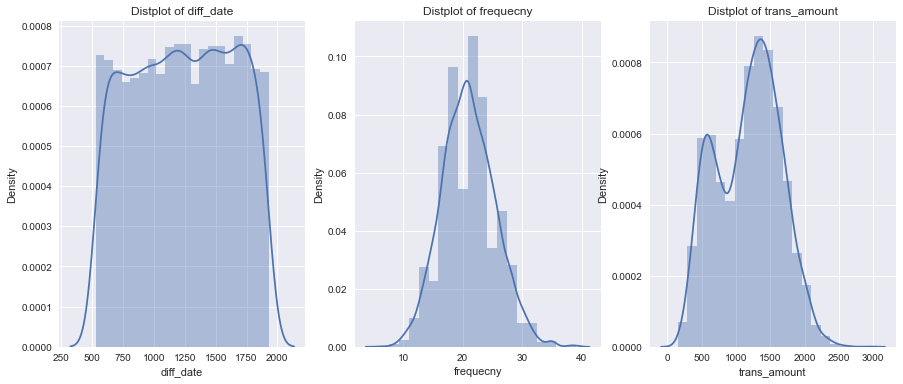

In [7]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['diff_date' ,'frequecny','trans_amount']:
    n += 1
    plt.subplot(1 , 3 , n)
    sns.distplot(df_total_transaction[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

# Standardized Variable (Optional but Strongly Recommended)


In [8]:
X = df_total_transaction.drop(['customer_id'], axis=1)

standardize = StandardScaler()
X_std = pd.DataFrame(standardize.fit_transform(X))
X_std.columns = X.columns
X_std.head()

,trans_amount,frequecny,diff_date
0,-0.359103,0.889986,0.144033
1,0.667091,1.113073,-1.752258
2,0.542574,0.443811,0.106753
3,1.029909,-0.225451,1.267392
4,-0.691865,0.666898,-0.556824


# <font color='blue'>K-Means Clustering</font>

# K-Means: with 2 variables with speculated k

Lets segment the data based on 2 variables: Annual Income and Spending Score (scaled spending amount between 0-100)

In [9]:
X_is = X_std[['frequecny', 'diff_date']].values

K-Means requires pre-defined number of clusters, eg. 3

In [10]:
k = 3
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_is)

centroids = k_means.cluster_centers_

Plot the segments

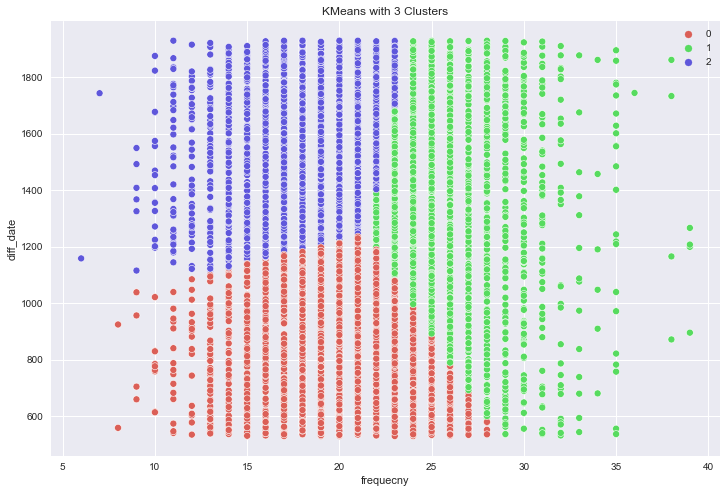

In [11]:
Segment = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['frequecny'], X['diff_date'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

`k_means.cluster_centers_` outputs the centroid based on standardized-data. We can easily calculate the centroid using original data

In [12]:
centroids = X[['frequecny','diff_date']].groupby(Segment, as_index=False).mean()
centroids

,frequecny,diff_date
0,19.707562,838.805170
1,26.181913,1350.079456
2,18.277685,1573.552433


# K-Means (2): 2 Variables with Elbow Method and Silhouette to Determine k

There are several methods to determine number of clusters for K-Means, eg. Elbow method using inertia or Silhouette score. 

In [13]:
def k_means_inertia_silhouette(X, k_max = 10, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(X)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()
    
    return inertia, silhouette

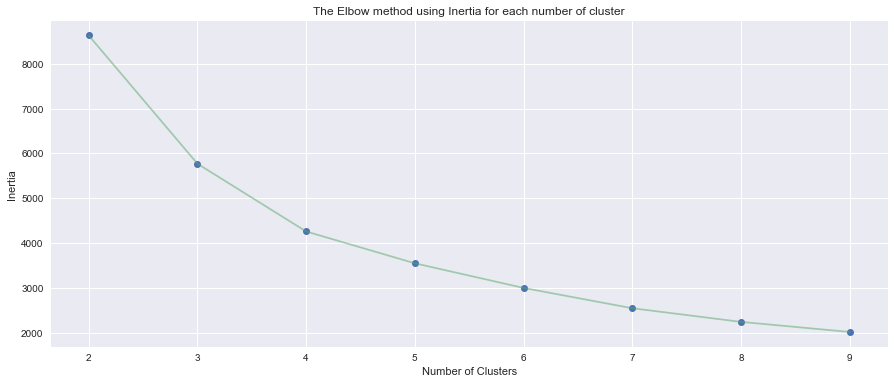

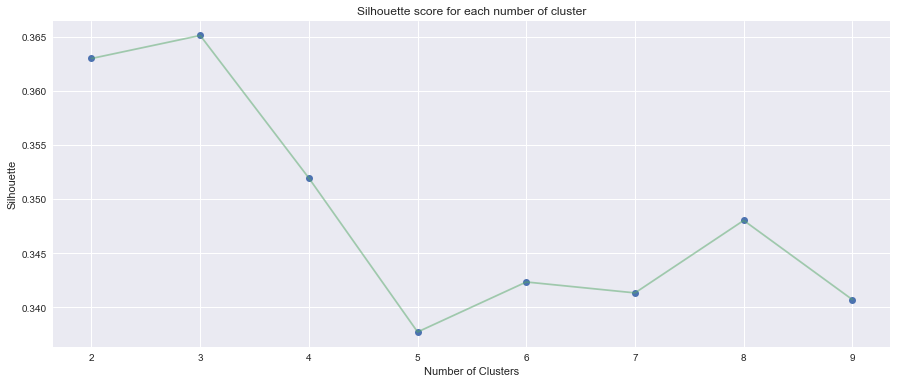

In [14]:
inertia, silhouette = k_means_inertia_silhouette(X = X_is)

Choose the k for which inertia becomes first starts to diminish. In the plot, this is visible as an elbow. If Silhouette score is used, choose the k with the highest score

In [15]:
k = 5
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_is)

KMeans(n_clusters=5, random_state=123)

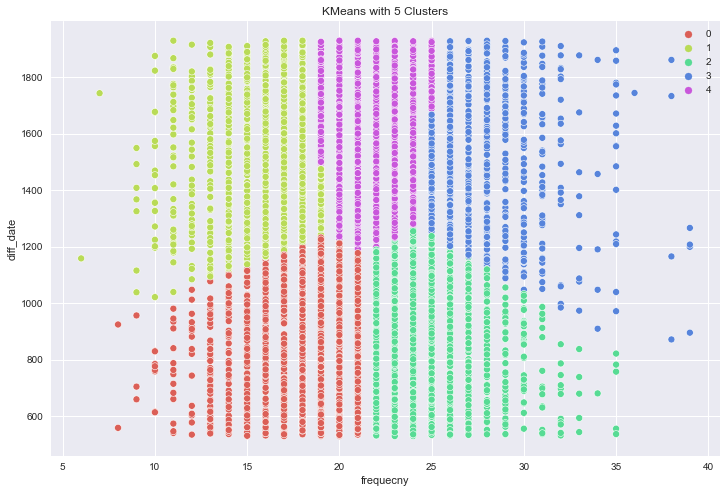

In [16]:
Segment = k_means.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['frequecny'], X['diff_date'], hue=Segment,
                palette=sns.color_palette('hls', k))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

In [17]:
centroids = X[['frequecny','diff_date']].groupby(Segment, as_index=False).mean()
centroids

,frequecny,diff_date
0,18.068830,853.992725
1,16.022082,1514.582019
2,24.748908,870.936681
3,27.852185,1507.203085
4,21.678359,1600.706302


# K-Means (3): 3 Variables with Elbow Method and Silhouette to Determine k

Lets try using 3 variables

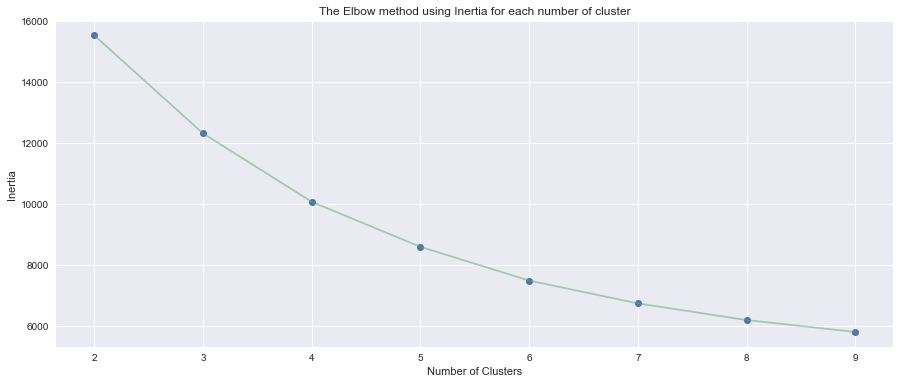

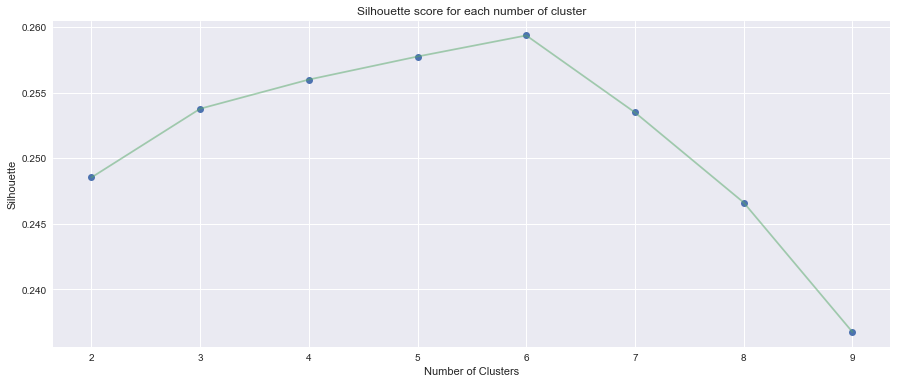

In [18]:
inertia, silhouette = k_means_inertia_silhouette(X_std, k_max = 10, init = 'k-means++')

In [19]:
k = 6
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_std)

KMeans(n_clusters=6, random_state=123)

In [20]:
Segment = k_means.labels_
X.groupby(Segment, as_index=False).mean()

,trans_amount,frequecny,diff_date
0,1528.632579,19.067202,857.712199
1,1433.585052,16.733677,1552.908076
2,1137.470709,26.567318,915.933196
3,662.185393,18.632959,912.865169
4,1514.285235,24.368289,1575.075503
5,662.152271,21.695459,1587.540516


Although you can use static 3d-scatter plot to visualize 3 dimension data, I recommend to use interactive plot using plotly. Note that plotly require javascript, it might not work in github page or other static document. If that is the case, import plotly visualisation to static image using `fig.show('svg')`.

In [21]:
X['Segment'] = list(map(str, Segment))
fig = px.scatter_3d(X, x='trans_amount', y='frequecny', z='diff_date', color='Segment',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg')

# Conclusion

In [22]:
#add cluster column to dataframe
clusters = pd.DataFrame(Segment, columns = ['clusters'], index = X_std.index)
rfmK= pd.concat([df_total_transaction, clusters], axis=1)
rfmK.head()

,customer_id,trans_amount,frequecny,diff_date,clusters
0,CS1112,1012,25,1293,2
1,CS1113,1490,26,530,2
2,CS1114,1432,23,1278,4
3,CS1115,1659,20,1745,1
4,CS1116,857,24,1011,2


In [23]:
#print customer that included in cluster 1, which from graphic we see is the highest group. 
print (rfmK[(rfmK['clusters'] == 1)])

     customer_id  trans_amount  frequecny  diff_date  clusters
3         CS1115          1659         20       1745         1
6         CS1118          1011         14       1663         1
8         CS1120          1677         15       1327         1
10        CS1122          1156         15       1152         1
11        CS1123          1331         13       1251         1
...          ...           ...        ...        ...       ...
6639      CS8751           613         10       1453         1
6643      CS8755          1052         19       1581         1
6659      CS8771           887         16       1771         1
6817      CS8929           901         15       1485         1
6868      CS8980           816         15       1799         1

[1164 rows x 5 columns]
